# Kernel padding experiments

In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
out_channels = 1
in_channels = 1
kernel_size = (2,2)
weights = torch.ones(out_channels,in_channels, kernel_size[0], kernel_size[1])
print(weights.shape)
print(weights)

In [ ]:
padded = F.pad(weights, [1, 1, 1, 1])
print(padded.shape)
print(padded)

In [ ]:
padded_upscale = padded[:, :, 1:, 1:] + padded[:, :, 1:, :-1] + padded[:, :, :-1, 1:] + padded[:, :, :-1, :-1]

print(padded[:, :, 1:, 1:], '\n\n', padded[:, :, 1:, :-1], '\n\n', padded[:, :, :-1, 1:], '\n\n', padded[:, :, :-1, :-1])

print(padded_upscale.shape)
print(padded_upscale /4)

In [ ]:
w_mat = weights.view(weights.size(0), -1)
w_mat

In [ ]:
from utils import max_singular_value
u = torch.FloatTensor(1, w_mat.size(0)).normal_(0, 1).cpu()
sigma, _u = max_singular_value(w_mat, u, 1)
sigma

In [ ]:
padded_upscale/sigma

In [ ]:
weights = weights[:, :, 1:, 1:] + weights[:, :, 1:, :-
                                            1] + weights[:, :, :-1, 1:] + weights[:, :, :-1, :-1]
w_mat = weights.view(weights.size(0), -1)
sigma, _u = max_singular_value(w_mat, self.u, 1)
self.u.copy_(_u)
return weights / sigma

# _output_padding experiments

In [ ]:
from typing import List

def _output_padding(input, output_padding, output_size, stride, padding, kernel_size, dilation=None):
        # type: (Tensor, Optional[List[int]], List[int], List[int], List[int], Optional[List[int]]) -> List[int]
        if output_size is None:
            ret = tuple(output_padding)  # converting to list if was not already
        else:
            k = input.dim() - 2
            if len(output_size) == k + 2:
                output_size = output_size[2:]
            if len(output_size) != k:
                raise ValueError(
                    "output_size must have {} or {} elements (got {})"
                    .format(k, k + 2, len(output_size)))

            min_sizes = torch.jit.annotate(List[int], [])
            max_sizes = torch.jit.annotate(List[int], [])
            for d in range(k):
                dim_size = ((input.size(d + 2) - 1) * stride[d] -
                            2 * padding[d] +
                            (dilation[d] if dilation is not None else 1) * (kernel_size[d] - 1) + 1)
                min_sizes.append(dim_size)
                max_sizes.append(min_sizes[d] + stride[d] - 1)

            for i in range(len(output_size)):
                size = output_size[i]
                min_size = min_sizes[i]
                max_size = max_sizes[i]
                if size < min_size or size > max_size:
                    raise ValueError((
                        "requested an output size of {}, but valid sizes range "
                        "from {} to {} (for an input of {})").format(
                            output_size, min_sizes, max_sizes, input.size()[2:]))

            res = torch.jit.annotate(List[int], [])
            for d in range(k):
                res.append(output_size[d] - min_sizes[d])

            ret = res
        return ret

In [ ]:

inputs = torch.rand((64, 3, 224, 224))

output_padding = _output_padding(inputs, output_padding=[0,0], output_size=[input_x * 2,input_y * 2], stride=[2,2], padding=[1,1], kernel_size=[3,3], dilation=None)

output_padding

In [ ]:
def pad_to_maintain_size(dilation, kernel_size):
    effective_filter_size = dilation * (kernel_size - 1) + 1
    if effective_filter_size % 2 == 0:
        print("In order to maintain input image size, effective filter size must be odd")
    return (effective_filter_size - 1) // 2

In [ ]:
from tqdm import tqdm

for stride in range(1,4):
        for dilation in range(1,3):
            for kernel_size in range(1,6, 2):
                failure = False
                sizes = []

                padding = pad_to_maintain_size(dilation, kernel_size)

                for input_size in range(0, 100):
                    output_size = input_size * 2
                    min_size = (input_size - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + 1
                    max_size = min_size + stride - 1
                    if output_size < min_size or output_size > max_size:
                        failure = True
                        sizes.append(input_x)

                message = 'fail' if failure else 'success'
                print(f'{message} stride: {stride}, padding: {padding}, dilation: {dilation}, kernel_size: {kernel_size}, failed sizes: {len(sizes)}')
        
       

from https://stats.stackexchange.com/questions/297678/how-to-calculate-optimal-zero-padding-for-convolutional-neural-networks

The possible values for the padding size, 𝑃, depends the input size 𝑊 (following the notation of the blog), the filter size 𝐹 and the stride 𝑆. We assume width and height are the same.

What you need to ensure is that the output size, (𝑊−𝐹+2𝑃)/𝑆+1, is an integer. When 𝑆=1 then you get your first equation 𝑃=(𝐹−1)/2 as necessary condition. But, in general, you need to consider the three parameters, namely 𝑊, 𝐹 and 𝑆 in order to determine valid values of 𝑃.


# Same padding experiments

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Union

def same_padding(conv_layer: Union[nn.Conv2d, nn.ConvTranspose2d], inputs: Tensor):
    in_height = inputs.size(2)
    in_width = inputs.size(3)
    dilation = conv_layer.dilation
    kernel_size = conv_layer.kernel_size
    filter_size = (dilation[0] * (kernel_size[0] - 1) + 1, dilation[1] * (kernel_size[1] - 1) + 1)

    print((in_height, in_width))
    print(filter_size)

    pad_along_height = dilation[0] * (kernel_size[0] - 1)
    pad_along_width = dilation[1] * (kernel_size[1] - 1)

    pad_top = pad_along_height // 2
    pad_bottom = pad_along_height - pad_top
    pad_left = pad_along_width // 2
    pad_right = pad_along_width - pad_left

    print(f'height: {pad_along_height}, width: {pad_along_width}')
    print(f'bottom: {pad_bottom}, top: {pad_top}, left: {pad_left}, right: {pad_right}')

    return F.pad(inputs, (pad_left, pad_right, pad_top, pad_bottom))

In [ ]:
inputs = torch.rand((64, 3, 122, 51))

conv_layer = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=(3,5), stride=1, dilation=1)

padded_inputs = same_padding(conv_layer, inputs)
output = conv_layer(padded_inputs)

print(inputs.size())
print(padded_inputs.size())
print(output.size())

# AdaIN experiments

In [3]:
from typing import Callable, Tuple
import unittest
import torch
from torch.tensor import Tensor
import torch.nn as nn
from modules.normalization.AdaptiveInstanceNormalization import AdaptiveInstanceNormalization

class TestAdaIN():
    #unit tests from https://zhangruochi.com/Components-of-StyleGAN/2020/10/13/
    def setUp(self) -> None:
        self.w_channels = 3
        self.intermediate_channels = None
        self.image_channels = 2
        image_size = 3
        n_test = 1
        self.input_shape = (n_test, self.image_channels, image_size, image_size)
        self.test_input = torch.ones(self.input_shape)
        self.test_w = torch.ones(n_test, self.w_channels)
        self.adain = AdaptiveInstanceNormalization(self.image_channels, self.w_channels, self.intermediate_channels)

        nn.init.constant_(self.adain.gamma_layer.weight, 0.25)
        nn.init.constant_(self.adain.beta_layer.weight, 0.2)
        
        for bias in (self.adain.gamma_layer.bias, self.adain.beta_layer.bias):
            nn.init.zeros_(bias)
            
        if self.adain.dense_layer is not None:
            nn.init.constant_(self.adain.dense_layer.weight, 0.2)
            nn.init.zeros_(self.adain.dense_layer.bias)

        self.test_w = torch.ones(n_test, self.w_channels)
        
    def test_layer_shape_correct(self):
        assert self.adain.gamma_layer(self.test_w).shape == self.adain.beta_layer(self.test_w).shape
        assert self.adain.gamma_layer(self.test_w).shape[-1] == self.image_channels
        assert tuple(self.adain(self.test_input, self.test_w).shape) == self.input_shape
    
    def test_conditional_norm(self) -> None:
        self.test_input[:, :, 0] = 0
        test_output = self.adain(self.test_input, self.test_w)
        assert(torch.abs(test_output[0, 0, 0, 0] - 3 / 5 + torch.sqrt(torch.tensor(9 / 8))) < 1e-4)
        assert(torch.abs(test_output[0, 0, 1, 0] - 3 / 5 - torch.sqrt(torch.tensor(9 / 32))) < 1e-4)

In [5]:
test_adain = TestAdaIN()
test_adain.setUp()
test_input = test_adain.test_input
test_input[:,:,0] = 0
test_w = test_adain.test_w
test_input.dim()

4

In [ ]:
test_output = test_adain.adain(test_input, test_w)

# (more) Spectral Norm experiments

In [ ]:
import copy
import unittest
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import spectral_norm 
from torch.nn.utils.spectral_norm import SpectralNorm
from torch.nn.init import constant_

from models.generative.ConvolutionalBlock import ConvolutionalBlock
from models.generative.ConvolutionalScale import DownscaleConv2d, FusedScale, UpscaleConv2d

parameter_name = 'weight'

input_shape = (1, 3, 6, 6)
in_channels, out_channels, kernel_size = 3, 6, 3
fn = lambda x: spectral_norm(x, name = parameter_name, dim = 0)
scale = fn(DownscaleConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, fused_scale=True))
nn.init.constant_(scale.weight, 1)
dummy1 = copy.deepcopy(scale)
dummy2 = copy.deepcopy(scale)

data = torch.ones(input_shape)

FusedScale(name=parameter_name)(dummy1, None)
SpectralNorm(name=parameter_name, dim=0)(dummy1, None)
dummy1_out = F.conv2d(data, dummy1.filter, dummy1.bias, stride=2, padding=dummy1.padding)

SpectralNorm(name=parameter_name, dim=0)(dummy2, None)
FusedScale(name=parameter_name)(dummy2, None)
dummy2_out = F.conv2d(data, dummy2.filter, dummy2.bias, stride=2, padding=dummy2.padding)


In [ ]:
torch.equal(dummy1_out, dummy2_out)

In [ ]:
import torch.nn as nn
from torch.nn.utils.spectral_norm import SpectralNorm, spectral_norm
import copy

in_channels, out_channels, kernel_size = 1, 1, 3
test_module = nn.Conv2d(in_channels, out_channels, kernel_size)
nn.init.constant_(test_module.weight, 1)

test_module2 = copy.deepcopy(test_module)

spectral_test1 = spectral_norm(test_module)
spectral_test2 = spectral_norm(test_module2)

print(spectral_test1.weight)
print(spectral_test2.weight)

In [ ]:
import torch.nn.functional as F
from torch import Tensor

def fused_scale(weight: Tensor) -> Tensor:
        padded = F.pad(weight, [1, 1, 1, 1])
        filter = padded[:, :, 1:, 1:] + padded[:, :, 1:, :-1] + padded[:, :, :-1, 1:] + padded[:, :, :-1, :-1]
        return filter

def _l2normalize(v, eps=1e-12):
    return v / (torch.norm(v) + eps)

def max_singular_value(W, u=None, Ip=1):
    """
    power iteration for weight parameter
    """
    #xp = W.data
    if Ip < 1:
        raise ValueError("Power iteration should be a positive integer")
    if u is None:
        u = torch.FloatTensor(1, W.size(0)).normal_(0, 1).cpu()
    _u = u
    for _ in range(Ip):
        _v = _l2normalize(torch.matmul(_u, W.data), eps=1e-12)
        _u = _l2normalize(torch.matmul(_v, torch.transpose(W.data, 0, 1)), eps=1e-12)
    sigma = torch.sum(F.linear(_u, torch.transpose(W.data, 0, 1)) * _v) # type: ignore
    return sigma, _u

def W_(weights, u):
    w_mat = weights.view(weights.size(0), -1)
    sigma, _u = max_singular_value(w_mat, u)
    u.copy_(_u) # type: ignore
    return weights / sigma

In [ ]:
import torch
tensor = torch.rand(1,1,3,3)
u = torch.Tensor(1, 1).normal_()

fused_scale_then_spectral = W_(fused_scale(tensor), u)
spectral_then_fused_scale = fused_scale(W_(tensor,u))
spectral_then_fused_then_spectral = W_(fused_scale(W_(tensor,u)), u)

print(torch.allclose(spectral_then_fused_then_spectral, fused_scale_then_spectral))

# OrderedDict experiments

In [ ]:
from collections import OrderedDict
from models.generative.DenseBlock import DenseBlock
from models.generative.ResidualBlock import ResidualBlock
from models.generative.ConvolutionalBlock import ConvolutionalBlock
from models.generative.AttentionBlock import AttentionBlock

pathgan_blocks = OrderedDict({
            ("dense_block_1", DenseBlock) : 1,
            ("dense_block_2", DenseBlock) : 2,
            ("res_block_1", ResidualBlock) : 3,
            ("upscale_block_1", ConvolutionalBlock) : 4,
            ("res_block_2", ResidualBlock) : 5,
            ("upscale_block_2", ConvolutionalBlock) : 6,
            ("res_block_2", ResidualBlock) : 7,
            ("attention_block", AttentionBlock) : 8,
            ("upscale_block_3", ConvolutionalBlock) : 9,
            ("res_block_3", ResidualBlock) : 10,
            ("upscale_layer_4", ConvolutionalBlock) : 11,
            ("res_block_4", ResidualBlock) : 12,
            ("upscale_block_4", ConvolutionalBlock) : 13,
            ("sigmoid_block", ConvolutionalBlock) : 14
        })

print(len(pathgan_blocks))

pathgan_blocks_as_tuple = (
            ("dense_block_1", DenseBlock),
            ("dense_block_2", DenseBlock),
            ("res_block_1", ResidualBlock),
            ("upscale_block_1", ConvolutionalBlock),
            ("res_block_2", ResidualBlock),
            ("upscale_block_2", ConvolutionalBlock),
            ("res_block_2", ResidualBlock),
            ("attention_block", AttentionBlock),
            ("upscale_block_3", ConvolutionalBlock),
            ("res_block_3", ResidualBlock),
            ("upscale_layer_4", ConvolutionalBlock),
            ("res_block_4", ResidualBlock),
            ("upscale_block_4", ConvolutionalBlock),
            ("sigmoid_block", ConvolutionalBlock),
        )

print(len(pathgan_blocks_as_tuple))

In [ ]:
len(pathgan_blocks_as_tuple)

In [ ]:
import torch.nn as nn
from torch.nn.utils.spectral_norm import SpectralNorm, spectral_norm
import copy

in_channels, out_channels, kernel_size = 1, 1, 3
test_module = nn.Conv2d(in_channels, out_channels, kernel_size)
nn.init.constant_(test_module.weight, 1)

test_module2 = copy.deepcopy(test_module)

spectral_test1 = spectral_norm(test_module)
spectral_test2 = spectral_norm(test_module2)

print(spectral_test1.weight)
print(spectral_test2.weight)

In [ ]:
import torch.nn.functional as F
from torch import Tensor

def fused_scale(weight: Tensor) -> Tensor:
        padded = F.pad(weight, [1, 1, 1, 1])
        filter = padded[:, :, 1:, 1:] + padded[:, :, 1:, :-1] + padded[:, :, :-1, 1:] + padded[:, :, :-1, :-1]
        return filter

def _l2normalize(v, eps=1e-12):
    return v / (torch.norm(v) + eps)

def max_singular_value(W, u=None, Ip=1):
    """
    power iteration for weight parameter
    """
    #xp = W.data
    if Ip < 1:
        raise ValueError("Power iteration should be a positive integer")
    if u is None:
        u = torch.FloatTensor(1, W.size(0)).normal_(0, 1).cpu()
    _u = u
    for _ in range(Ip):
        _v = _l2normalize(torch.matmul(_u, W.data), eps=1e-12)
        _u = _l2normalize(torch.matmul(_v, torch.transpose(W.data, 0, 1)), eps=1e-12)
    sigma = torch.sum(F.linear(_u, torch.transpose(W.data, 0, 1)) * _v) # type: ignore
    return sigma, _u

def W_(weights, u):
    w_mat = weights.view(weights.size(0), -1)
    sigma, _u = max_singular_value(w_mat, u)
    u.copy_(_u) # type: ignore
    return weights / sigma

In [ ]:
import torch
tensor = torch.rand(1,1,3,3)
u = torch.Tensor(1, 1).normal_()

fused_scale_then_spectral = W_(fused_scale(tensor), u)
spectral_then_fused_scale = fused_scale(W_(tensor,u))
spectral_then_fused_then_spectral = W_(fused_scale(W_(tensor,u)), u)

print(torch.allclose(spectral_then_fused_then_spectral, fused_scale_then_spectral))

# Generator class experiments

In [ ]:
from modules.generative.Generator import Generator

generator = Generator()
for child in generator.named_children():
    print(type(child[1]))

In [ ]:
from modules.blocks.ConvolutionalBlock import UpscaleBlock
print(type(UpscaleBlock(1,1,1)))

In [1]:
import json
from collections import OrderedDict
from modules.blocks.DenseBlock import DenseBlock
from modules.blocks.ResidualBlock import ResidualBlock
from modules.generative.Generator import Generator

generator = Generator()
generator

TypeError: __init__() got an unexpected keyword argument 'initialization'

In [26]:
import torch

data = torch.rand((10, 200))
latent_in = torch.zeros((10, 200))

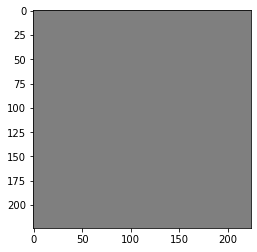

In [27]:
out = generator(data, latent_in)

import matplotlib.pyplot as plt

def view_image(tensor, index):
    permuted = tensor[index].permute(1, 2, 0)
    plt.imshow(permuted.detach().numpy())

view_image(out, 0)

In [2]:
for np in generator.named_parameters():
    print(np[0], '\n')

dense_block_0.dense_layer.bias 

dense_block_0.dense_layer.weight_orig 

dense_block_0.noise_input.weight 

dense_block_0.normalization.dense_layer.bias 

dense_block_0.normalization.dense_layer.weight_orig 

dense_block_0.normalization.gamma_layer.bias 

dense_block_0.normalization.gamma_layer.weight_orig 

dense_block_0.normalization.beta_layer.bias 

dense_block_0.normalization.beta_layer.weight_orig 

dense_block_1.dense_layer.bias 

dense_block_1.dense_layer.weight_orig 

dense_block_1.noise_input.weight 

dense_block_1.normalization.dense_layer.bias 

dense_block_1.normalization.dense_layer.weight_orig 

dense_block_1.normalization.gamma_layer.bias 

dense_block_1.normalization.gamma_layer.weight_orig 

dense_block_1.normalization.beta_layer.bias 

dense_block_1.normalization.beta_layer.weight_orig 

res_block_0.part_1.conv_layer.bias 

res_block_0.part_1.conv_layer.weight_orig 

res_block_0.part_1.noise_input.weight 

res_block_0.part_1.normalization.dense_layer.bias 

res_block

In [25]:
output_image_size = (224,256)
number_of_synthesis_blocks = 5
        
upscale_factor = 2 ** number_of_synthesis_blocks
image_size_valid = all(side % upscale_factor == 0 for side in output_image_size)
image_size_valid

True

# Reshape experiments

In [5]:
import torch 

input = torch.rand(10, 12544)
output = torch.reshape(input, (10, 256, 7, 7))
output.shape

torch.Size([10, 256, 7, 7])